In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature"]
label_cols = ["Outflow(t+1)"]

In [4]:
new_df = df.filter(["Precipitation","Temperature", "Outflow"], axis=1)

In [5]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):
    #Splitting training and test data
    df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
    x_train = df_train.loc[:,train_cols].values
    y_train = df_train.loc[:,label_cols].values
    x_test = df_test.loc[:,train_cols].values
    y_test = df_test.loc[:,label_cols].values    
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [7]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)
X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual = data_processing(lag_df)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (148416, 18, 2) (148416,)



length of time-series i/o (37091, 18, 2) (37091,)


In [8]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    lstm1 = LSTM(units=16, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm1)
    lstm2 = LSTM(units=32, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    lstm3 = LSTM(units=64)(dropout2)
    dropout3 = Dropout(0.2)(lstm3)

    dense1 = Dense(128, activation='relu')(dropout3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)


In [9]:
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []
models = []
def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
        models.append(model)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values_unnor, model

predicted_y_values_unnor, model = run_iteration(20,10)

Iteration: 1
Epoch 1/10
4638/4638 [==============================] - 98s 21ms/step - loss: 6.1486e-04 - val_loss: 0.0012
Epoch 2/10
4638/4638 [==============================] - 119s 26ms/step - loss: 5.4963e-04 - val_loss: 0.0011
Epoch 3/10
4638/4638 [==============================] - 104s 22ms/step - loss: 5.2983e-04 - val_loss: 0.0012
Epoch 4/10
4638/4638 [==============================] - 97s 21ms/step - loss: 5.2387e-04 - val_loss: 0.0011
Epoch 5/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.1544e-04 - val_loss: 0.0011
Epoch 6/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.1617e-04 - val_loss: 0.0011
Epoch 7/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.1055e-04 - val_loss: 0.0011
Epoch 8/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.0519e-04 - val_loss: 0.0011
Epoch 9/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.0550e-04 - val_loss: 0.0011
Epoch 10/10
4

Epoch 6/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.1768e-04 - val_loss: 0.0011
Epoch 7/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.1088e-04 - val_loss: 0.0011
Epoch 8/10
4638/4638 [==============================] - 85s 18ms/step - loss: 5.0511e-04 - val_loss: 0.0011
Epoch 9/10
4638/4638 [==============================] - 86s 19ms/step - loss: 5.0517e-04 - val_loss: 0.0011
Epoch 10/10
4638/4638 [==============================] - 87s 19ms/step - loss: 4.9732e-04 - val_loss: 0.0011
Iteration: 9
Epoch 1/10
4638/4638 [==============================] - 99s 21ms/step - loss: 6.1910e-04 - val_loss: 0.0011
Epoch 2/10
4638/4638 [==============================] - 86s 18ms/step - loss: 5.3843e-04 - val_loss: 0.0011
Epoch 3/10
4638/4638 [==============================] - 86s 19ms/step - loss: 5.2959e-04 - val_loss: 0.0011
Epoch 4/10
4638/4638 [==============================] - 87s 19ms/step - loss: 5.2405e-04 - val_loss: 0.0011
Epoch 5/10
463

Iteration: 16
Epoch 1/10
4638/4638 [==============================] - 86s 19ms/step - loss: 6.0017e-04 - val_loss: 0.0012
Epoch 2/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.4347e-04 - val_loss: 0.0011
Epoch 3/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.3338e-04 - val_loss: 0.0012
Epoch 4/10
4638/4638 [==============================] - 85s 18ms/step - loss: 5.2360e-04 - val_loss: 0.0011
Epoch 5/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.1854e-04 - val_loss: 0.0011
Epoch 6/10
4638/4638 [==============================] - 85s 18ms/step - loss: 5.1447e-04 - val_loss: 0.0012
Epoch 7/10
4638/4638 [==============================] - 84s 18ms/step - loss: 5.0568e-04 - val_loss: 0.0011
Epoch 8/10
4638/4638 [==============================] - 85s 18ms/step - loss: 5.0353e-04 - val_loss: 0.0011
Epoch 9/10
4638/4638 [==============================] - 85s 18ms/step - loss: 5.0416e-04 - val_loss: 0.0011
Epoch 10/10
46

In [10]:
model.save("lstm_model1_2_features_pre_tem.hdf5")

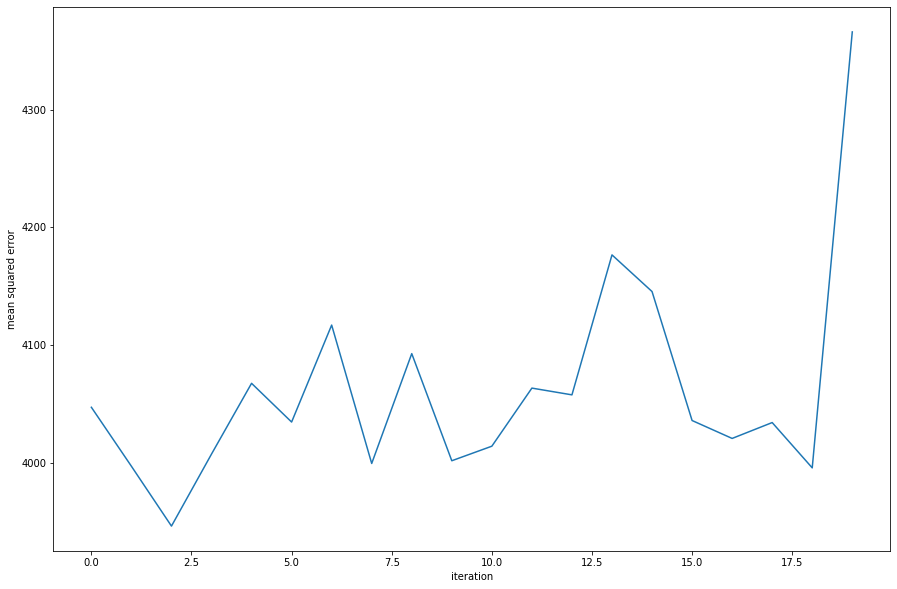

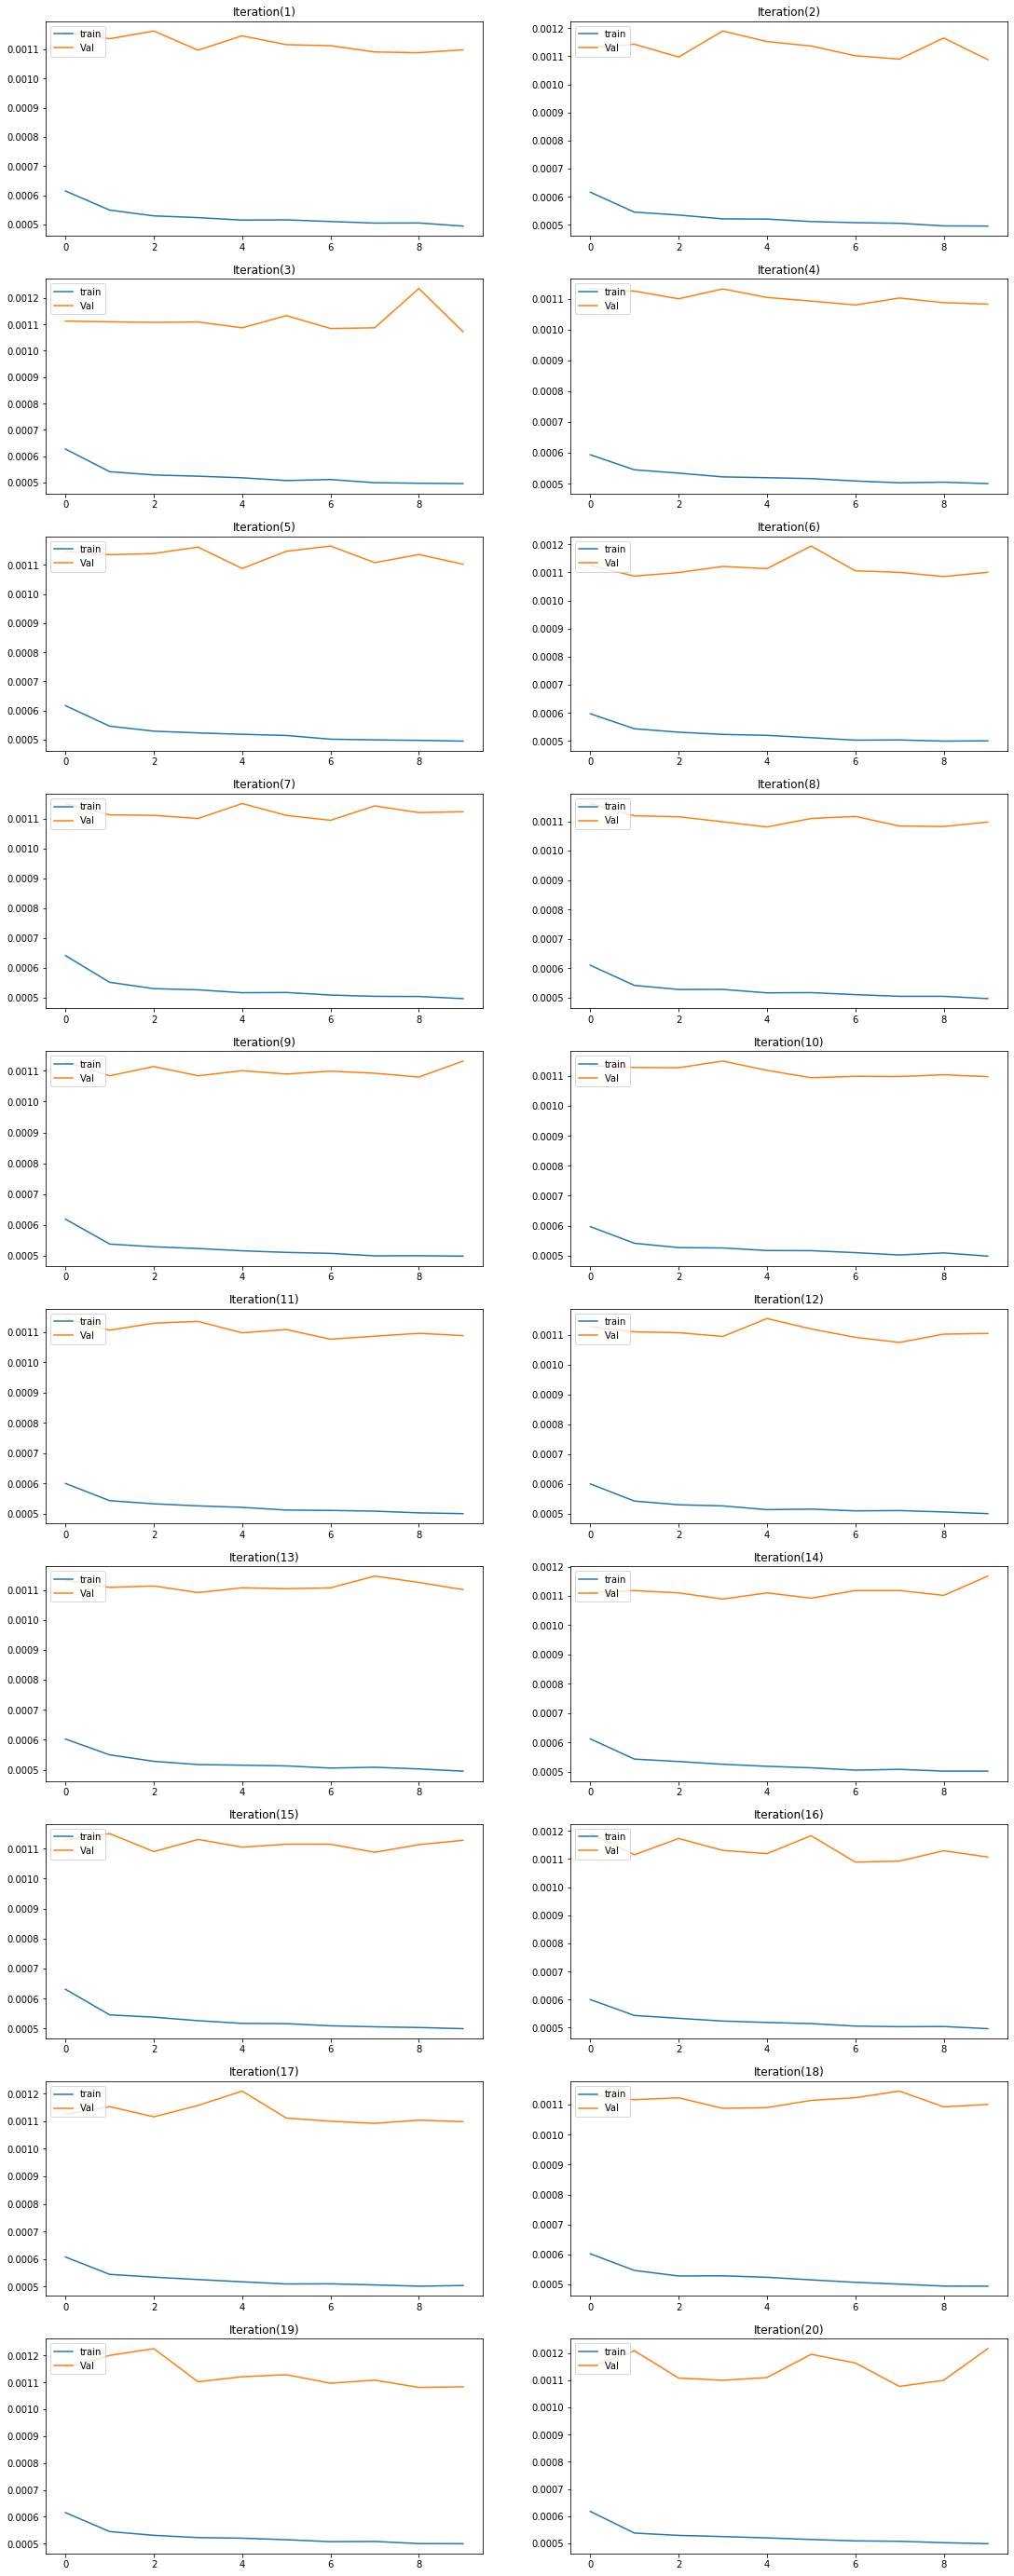

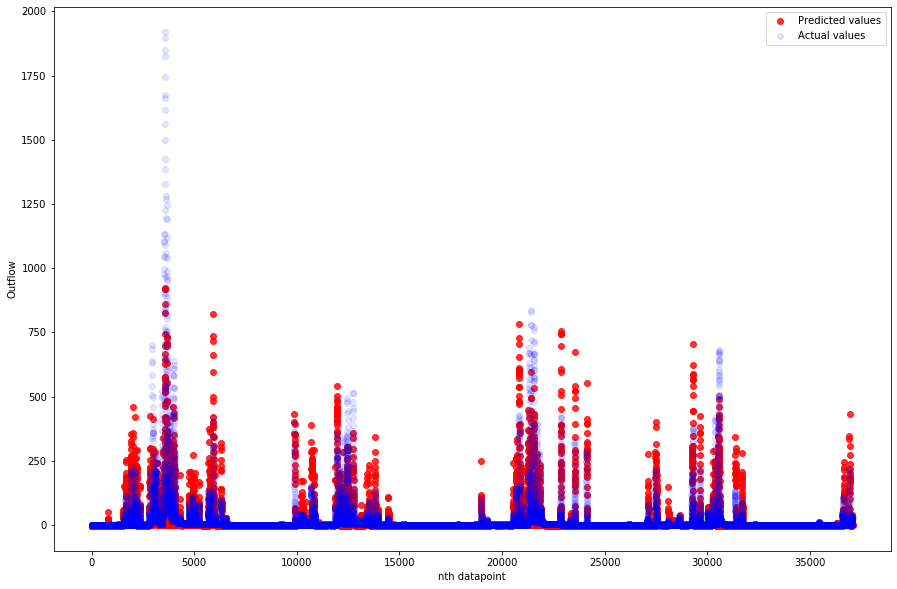

In [11]:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(10, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(10):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch[index])
            axs[row, col].plot(val_loss_over_epoch[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test_actual, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [12]:
mse_for_iter

[4047.2071931308637,
 3997.1199923840627,
 3946.3127002583014,
 4007.486502329099,
 4067.554195389901,
 4034.67526121901,
 4117.021405507723,
 3999.4954466762433,
 4092.770837549967,
 4001.801186925544,
 4014.162948386793,
 4063.4912495692056,
 4057.7551127825855,
 4176.6111508063495,
 4145.476124066188,
 4035.965216919073,
 4020.7554138052838,
 4034.2286166610083,
 3995.761421184003,
 4365.9652870876735]

In [13]:
print(np.mean(mse_for_iter))

4061.080863131944


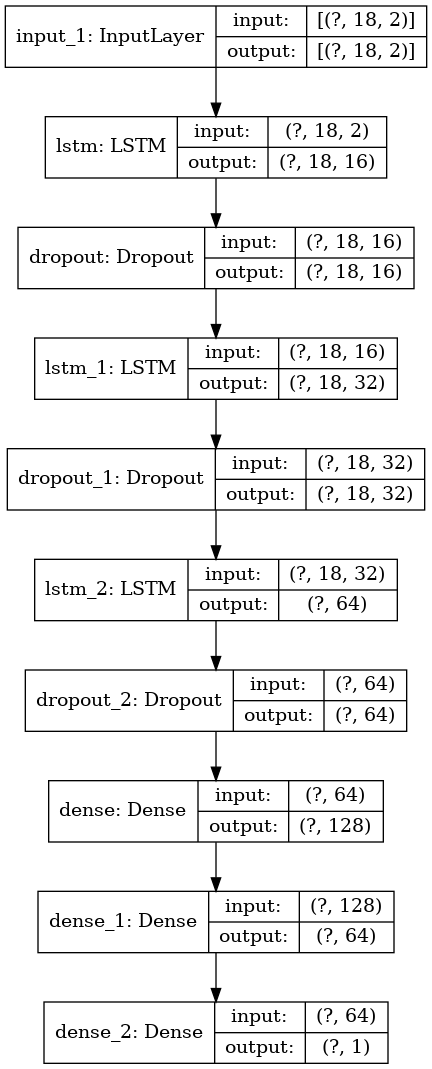

In [14]:
plot_model(model, show_shapes=True)